Brian Eager shared this fill-in-the-blank style Jupyter Notebook worksheet in a class MS Teams post.

# Week 2 Exercises: Itemsets

In [1]:
from __future__ import print_function, division
import json
from copy import copy, deepcopy
import pandas as pd
import time
import argparse
import sys
import traceback
import matplotlib.pyplot as plt 
import numpy as np
import math
from random import random
from scipy.spatial.distance import cdist
import scipy
from itertools import combinations
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial.distance import cdist
import scipy
from matplotlib import pyplot
from scipy import stats
%matplotlib inline

## 1. Closed Itemset Mining

Implement the CHARM algorithm for frequent closed itemset mining (see Algorithm 9.2 in chapter 9). Download the file mushroom.txt for your runs. Each line of the file contains a transaction, i.e., as set of items that occur together. The transactions do not have to be of the same length, but you may assume that each line will be sorted on the items.

Your script should accept the filename and minimum support value from the command line. It should be run as: ScriptName mushroom.txt MINSUP. Here MINSUP is in absolute numbers.

Your script should output all the frequent closed itemsets in the following format:

closed itemset - support

with one itemset and its support per line. It should also print the total number of frequent closed itemsets on the last line of the output.

Run your code on mushroom.txt for two different values of minsup, namely minsup = 5000, and minsup = 3000, and record the output.

from Prof. D's document in Teams:

The charm.py script contains two classes: DataPreparation and CharmAlgorithm.

DataPreparation class has three methods:

•	import_data(self, filename) - imports input data and writes it in a transactional form, as a list of tuples: {'tid': tid, 'item': element}

•	transform_data(self) - generates list of transactions for each element in the input data and writes to dataframe

•	get_frequent_items(self, min_sup) - returns dataframe with all one-element itemsets with relative_support => min_sup

CharmAlgorithm class contains implementation of the Charm algorithm. It has two main methods containing algorithm logic:

•	charm_extend(self, items_grouped) - main algorithm responsible for finding closed itemsets, output is stored in self.result dataframe, the method considers each combination of itemset-transaction_id pairs appearing in items_grouped input dataframe and executes charm_property() method

•	charm_property(self, row1, row2, items, new_item, new_tid) - applies one of the four properties on two given itemset-transaction_id-pairs

### CHARM Algorithm with minsup=3000

In [2]:
# This totally errored out until I figured out that the error was due to using the parse args lines, which are meant to be run on a command line
# To fix the error, I need to get rid of the parser and fill args directly instead of getting it from parse_args
# Anyway that is what this site says:    https://github.com/adventuresinML/adventures-in-ml-code/issues/12
# I got help with removing the arg parse stuff from Andrea Fox

'''Mines frequent closed itemsets without performing direct closure checking. Uses a vertical tidset intersection based method.'''
import json
from copy import copy, deepcopy
import pandas as pd
import time

class DataPreparation:
    transactional = []        # where the for loop under def import_data() is going to put/append the new tuples
    tid_count = 0
    # the self parameter is a reference to the current instance of the class, used to access variables that belong to the class    
    def import_data(self, filename):                   # writes the imported data as a list of tuples
        with open(filename, 'r') as file:
            tid = 1
            for line in file:                          # read each line, get rid of commas, spaces, stuff like that
                    line = line.strip().split()
                    for element in line:
                        self.transactional.append({'tid': tid, 'item': element})       # append each new tuple to the list
                    tid += 1                           # add 1 to the tid so we don't have duplicates
        self.tid_count = tid - 1                       # because we started with tid=1 to begin with(?)
                    
    def transform_data(self):            # generate list of transactions for each element in the input data & write to dataframe
        df = pd.DataFrame(self.transactional)          # pull the tuples I put in the transactional list into a dataframe
        self.itemsGrouped = df.groupby(['item'])['tid'].apply(list)
        self.itemsGrouped = pd.DataFrame({'item': self.itemsGrouped.index, 'tid': self.itemsGrouped.values})        # ?
        self.itemsGrouped['item'] = self.itemsGrouped['item'].apply(lambda x: {x})                                  # ?
                    
    def get_frequent_items(self, min_sup):           # return dataframe w/ all 1-element itemsets w/ relative_support => min_sup
        print('Tid count: {}'.format(self.tid_count))  # tells me how many tids we imported (from import_data() function above)
        return self.itemsGrouped[self.itemsGrouped['tid'].map(len) >= min_sup]      # return only the tids w/ len >= min_sup

class CharmAlgorithm:
    def __init__(self, min_sup_config, tid_count):             # arguments are defined under the if __name ... main__':
        self.result = pd.DataFrame(columns=['item', 'tid', 'support'])
        self.min_sup = min_sup_config
    
    @staticmethod
    def replace_values(df, column, find, replace):
        for row in df.itertuples():
            if find <= row[column]:
                row[column].update(replace)
    
    def charm_property(self, row1, row2, items, new_item, new_tid):
        if len(new_tid) >= self.min_sup:
            if set(row1[2]) == set(row2[2]):
                # remove row2[1] from items
                items = items[items['item'] != row2[1]]
                # replace all row1[1] with new_item
                find = copy(row1[1])
                self.replace_values(items, 1, find, new_item)
                self.replace_values(self.items_tmp, 1, find, new_item)
            elif set(row1[2]).issubset(set(row2[2])):
                # replace all row1[1] with new_item
                find = copy(row1[1])
                self.replace_values(items, 1, find, new_item)
                self.replace_values(self.items_tmp, 1, find, new_item)
            elif set(row2[2]).issubset(set(row1[2])):
                # remove row2[1] from items
                items = items[items['item'] != row2[1]]
                # add {item, tid} to self.items_tmp
                self.items_tmp = self.items_tmp.append({'item': new_item, 'tid': new_tid}, ignore_index=True)
            elif set(row1[2]) != set(row2[2]):
                # add {item,tid} to self.items_tmp
                self.items_tmp = self.items_tmp.append({'item': new_item, 'tid': new_tid}, ignore_index=True)
                
    def charm_extend(self, items_grouped):
        # sort items by ascending support
        s = items_grouped.tid.str.len().sort_values().index
        items_grouped = items_grouped.reindex(s).reset_index(drop=True)
        
        for row1 in items_grouped.itertuples():
            self.items_tmp = pd.DataFrame(columns=['item', 'tid'])
            for row2 in items_grouped.itertuples():
                if row2[0] >= row1[0]:
                    item = set()
                    item.update(row1[1])
                    item.update(row2[1])
                    tid = list(set(row1[2]) & set(row2[2]))
                    self.charm_property(row1, row2, items_grouped, item, tid)
            if not self.items_tmp.empty:
                self.charm_extend(self.items_tmp)
            
            is_subsumption = False                            # check if item subsumed
            for row in self.result.itertuples():
                if row1[1].issubset(row[1]) and set(row[2]) == set(row1[2]):
                    is_subsumption = True
                    break
            if not is_subsumption:                            # append to result if element not subsumed
                self.result = self.result.append({'item': row1[1], 'tid': row1[2], 'support': len(row1[2])}, ignore_index=True)
                     
    def write_result_to_file(self, result_file):
        self.result.to_csv(result_file, sep='\t', columns=['item', 'support'], index=False)
        
    def write_result_to_smfl_format(self, result_file):
        self.result['item'] = self.result['item'].apply(lambda x: sorted(map(int,x)))
        self.result.to_csv(result_file, sep='\t', columns=['item', 'support'],index=False, header = False)
        
if __name__ == '__main__':
    start = time.time()
       
    # prepration - Goes to class DataPreparation at very beginning
    data = DataPreparation()                  # create an object named 'data
    data.import_data('mushroom.txt')          # giving the filename argument to value of 'mushroom.txt'
    data.transform_data()
    freq = data.get_frequent_items(3000)      # giving the min_sup argument the value of 3000
    
    # algorithm
    algorithm = CharmAlgorithm(3000, data.tid_count)     # the min_sup_config is 3000 and use the tid_count from previous class
    dataframe = algorithm.result
    print(algorithm.charm_extend(freq))
    
    # write to file
    spmf_format = False
    if spmf_format == True:
        algorithm.write_result_to_smfl_format('output1.csv')
    else:
        algorithm.write_result_to_file('output1.csv')

    end = time.time()
    print("#################################################################")
    print('File: '+'mushroom.txt')
    print('Python elapsed time: ' + str(round((end - start), 3)) + ' s')
    
'''Output is
Tid count: 8124
None
#################################################################
File: mushroom.txt
Python elapsed time: 4.41 s'''

Tid count: 8124
None
#################################################################
File: mushroom.txt
Python elapsed time: 3.56 s


'Output is\nTid count: 8124\nNone\n#################################################################\nFile: mushroom.txt\nPython elapsed time: 4.41 s'

### CHARM Algorithm with minsup=5000

In [3]:
import json
from copy import copy, deepcopy
import pandas as pd
import time

class DataPreparation:
    transactional = []
    tid_count = 0
        
    def import_data(self, filename):
        with open(filename, 'r') as file:
            tid = 1
            for line in file:
                    line = line.strip().split()
                    for element in line:
                        self.transactional.append({'tid': tid, 'item': element})
                    tid += 1
        self.tid_count = tid - 1
                    
    def transform_data(self):
        df = pd.DataFrame(self.transactional)
        self.itemsGrouped = df.groupby(['item'])['tid'].apply(list)
        self.itemsGrouped = pd.DataFrame({'item': self.itemsGrouped.index, 'tid': self.itemsGrouped.values})
        self.itemsGrouped['item'] = self.itemsGrouped['item'].apply(lambda x: {x})
                    
    def get_frequent_items(self, min_sup):
        print('Tid count: {}'.format(self.tid_count))
        return self.itemsGrouped[self.itemsGrouped['tid'].map(len) >= min_sup]

class CharmAlgorithm:
    def __init__(self, min_sup_config, tid_count):
        self.result = pd.DataFrame(columns=['item', 'tid', 'support'])
        self.min_sup = min_sup_config
    
    @staticmethod
    def replace_values(df, column, find, replace):
        for row in df.itertuples():
            if find <= row[column]:
                row[column].update(replace)
    
    def charm_property(self, row1, row2, items, new_item, new_tid):
        if len(new_tid) >= self.min_sup:
            if set(row1[2]) == set(row2[2]):
                # remove row2[1] from items
                items = items[items['item'] != row2[1]]
                # replace all row1[1] with new_item
                find = copy(row1[1])
                self.replace_values(items, 1, find, new_item)
                self.replace_values(self.items_tmp, 1, find, new_item)
            elif set(row1[2]).issubset(set(row2[2])):
                # replace all row1[1] with new_item
                find = copy(row1[1])
                self.replace_values(items, 1, find, new_item)
                self.replace_values(self.items_tmp, 1, find, new_item)
            elif set(row2[2]).issubset(set(row1[2])):
                # remove row2[1] from items
                items = items[items['item'] != row2[1]]
                # add {item, tid} to self.items_tmp
                self.items_tmp = self.items_tmp.append({'item': new_item, 'tid': new_tid}, ignore_index=True)
            elif set(row1[2]) != set(row2[2]):
                # add {item,tid} to self.items_tmp
                self.items_tmp = self.items_tmp.append({'item': new_item, 'tid': new_tid}, ignore_index=True)
                
    def charm_extend(self, items_grouped):
        # sort items by ascending support
        s = items_grouped.tid.str.len().sort_values().index
        items_grouped = items_grouped.reindex(s).reset_index(drop=True)
        
        for row1 in items_grouped.itertuples():
            self.items_tmp = pd.DataFrame(columns=['item', 'tid'])
            for row2 in items_grouped.itertuples():
                if row2[0] >= row1[0]:
                    item = set()
                    item.update(row1[1])
                    item.update(row2[1])
                    tid = list(set(row1[2]) & set(row2[2]))
                    self.charm_property(row1, row2, items_grouped, item, tid)
            if not self.items_tmp.empty:
                self.charm_extend(self.items_tmp)
            
            is_subsumption = False                            # check if item subsumed
            for row in self.result.itertuples():
                if row1[1].issubset(row[1]) and set(row[2]) == set(row1[2]):
                    is_subsumption = True
                    break
            if not is_subsumption:                            # append to result if element not subsumed
                self.result = self.result.append({'item': row1[1], 'tid': row1[2], 'support': len(row1[2])}, ignore_index=True)
                return self.result                            ### not sure if I should return this here or not!
                          
    def write_result_to_file(self, result_file):
        self.result.to_csv(result_file, sep='\t', columns=['item', 'support'], index=False)
        
    def write_result_to_smfl_format(self, result_file):
        self.result['item'] = self.result['item'].apply(lambda x: sorted(map(int,x)))
        self.result.to_csv(result_file, sep='\t', columns=['item', 'support'],index=False, header = False)
        
if __name__ == '__main__':
    start = time.time()
       
    # prepration
    data = DataPreparation()
    data.import_data('mushroom.txt')
    data.transform_data()
    freq = data.get_frequent_items(5000)
    
    # algorithm
    algorithm = CharmAlgorithm(5000, data.tid_count)
    dataframe = algorithm.result
    print(algorithm.charm_extend(freq))
    
    # write to file
    spmf_format = False
    if spmf_format == True:
        algorithm.write_result_to_smfl_format('output2.csv')
    else:
        algorithm.write_result_to_file('output2.csv')

    end = time.time()
    print("#################################################################")
    print('File: '+'mushroom.txt')
    print('Python elapsed time: ' + str(round((end - start), 3)) + ' s')
    
'''Output is:
Tid count: 8124
       item                                                tid support
0  {85, 59}  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    5176
#################################################################
File: mushroom.txt
Python elapsed time: 0.264 s

'Output is:\nTid count: 8124\nNone\n#################################################################\nFile: mushroom.txt\nPython elapsed time: 0.561 s'
'''

Tid count: 8124
       item                                                tid support
0  {85, 59}  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    5176
#################################################################
File: mushroom.txt
Python elapsed time: 0.259 s


"Output is:\nTid count: 8124\n       item                                                tid support\n0  {85, 59}  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    5176\n#################################################################\nFile: mushroom.txt\nPython elapsed time: 0.264 s\n\n'Output is:\nTid count: 8124\nNone\n#################################################################\nFile: mushroom.txt\nPython elapsed time: 0.561 s'\n"

In [4]:
# from instructor code again.  Torrey thought she could help.  I ended up stuck in same spot again.  Tried unittest this time.
import json
from copy import copy, deepcopy
import pandas as pd
import time
import argparse

import unittest

class DataPreparation:
    transactional = []
    tid_count = 0

    def import_data(self, filename):
        with open(filename, 'r') as file:
            tid = 1
            for line in file:
                line = line.strip().split()
                for element in line:
                    self.transactional.append({'tid': tid, 'item': element})
                tid += 1
        self.tid_count = tid - 1

    def transform_data(self):
        df = pd.DataFrame(self.transactional)
        self.itemsGrouped = df.groupby(['item'])['tid'].apply(list)
        self.itemsGrouped = pd.DataFrame({'item': self.itemsGrouped.index, 'tid': self.itemsGrouped.values})
        self.itemsGrouped['item'] = self.itemsGrouped['item'].apply(lambda x: {x})

    def get_frequent_items(self, min_sup):
        return self.itemsGrouped[self.itemsGrouped['tid'].map(len) >= min_sup]

class CharmAlgorithm:
    def __init__(self, min_sup_config, tid_count):
        self.result = pd.DataFrame(columns=['item', 'tid', 'support'])
        self.min_sup = min_sup_config
    @staticmethod
    def replace_values(df, column, find, replace):
        for row in df.itertuples():
            if find <= row[column]:
                row[column].update(replace)

    def charm_property(self, row1, row2, items, new_item, new_tid):
        if len(new_tid) >= self.min_sup:
            if set(row1[2]) == set(row2[2]):
                # remove row2[1] from items
                items = items[items['item'] != row2[1]]
                # replace all row1[1] with new_item
                find = copy(row1[1])
                self.replace_values(items, 1, find, new_item)
                self.replace_values(self.items_tmp, 1, find, new_item)
            elif set(row1[2]).issubset(set(row2[2])):
                # replace all row1[1] with new_item
                find = copy(row1[1])
                self.replace_values(items, 1, find, new_item)
                self.replace_values(self.items_tmp, 1, find, new_item)
            elif set(row2[2]).issubset(set(row1[2])):
                # remove row2[1] from items
                items = items[items['item'] != row2[1]]
                # add {item, tid} to self.items_tmp
                self.items_tmp = self.items_tmp.append({'item': new_item, 'tid': new_tid}, ignore_index=True)
                # sort items by ascending support
                # s = self.items_tmp.tid.str.len().sort_values().index
                # self.items_tmp = self.items_tmp.reindex(s).reset_index(drop=True)
            elif set(row1[2]) != set(row2[2]):
                # add {item, tid} to self.items_tmp
                self.items_tmp = self.items_tmp.append({'item': new_item, 'tid': new_tid}, ignore_index=True)
               
    def charm_extend(self, items_grouped):
        # sort items by ascending support
        s = items_grouped.tid.str.len().sort_values().index
        items_grouped = items_grouped.reindex(s).reset_index(drop=True)

        for row1 in items_grouped.itertuples():
            self.items_tmp = pd.DataFrame(columns=['item', 'tid'])
            for row2 in items_grouped.itertuples():
                if row2[0] >= row1[0]:
                    item = set()
                    item.update(row1[1])
                    item.update(row2[1])
                    tid = list(set(row1[2]) & set(row2[2]))
                    self.charm_property(row1, row2, items_grouped, item, tid)
            if not self.items_tmp.empty:
                self.charm_extend(self.items_tmp)
            # check if item subsumed
            is_subsumption = False
            for row in self.result.itertuples():
                if row1[1].issubset(row[1]) and set(row[2]) == set(row1[2]):
                    is_subsumption = True
                    break
            # append to result if element not subsumed
            if not is_subsumption:
                self.result = self.result.append({'item': row1[1], 'tid': row1[2], 'support': len(row1[2])}, ignore_index=True)

    def write_result_to_file(self, result_file):
        self.result.to_csv(result_file, sep='\t', columns=['item', 'support'], index=False)

    def write_result_to_smfl_format(self, result_file):
        self.result['item'] = self.result['item'].apply(lambda x: sorted(map(int, x)))
        self.result.to_csv(result_file, sep='\t', columns=['item', 'support'], index=False, header=False)

if __name__ == '__main__':
    '''from https://medium.com/@vladbezden/using-python-unittest-in-ipython-or-jupyter-732448724e31  - 
    Passing explicit list to unittest.main will prevent IPython and Jupyter look at sys.argv. 
    Passing exit=False will prevent unittest.main to shutdown the kernell process.
    '''
    unittest.main(argv=['first-arg-is-ignored'], exit=False)   
    start = time.time()

    # parse args
    parser = argparse.ArgumentParser(description='Generate closed frequent itemsets')
    parser.add_argument('-f', '--filename', help="Name of the file with data for itemset generation", required=True)
    # parser.add_argument('-f', '--fff', help="a dummy argument to fool ipython", default="1")   This didn't help.
    parser.add_argument('-s', '--support', help="Minimum support for frequent itemsets", required=True, type=float)
    parser.add_argument('--output', help="Output file name", required=False, default='output.txt')
    parser.add_argument('--spmf-format', help="Specify output file format as SPMF", required=False, action='store_true')
    args = parser.parse_args()

    # preparation
    data = DataPreparation()
    data.import_data(args.filename)
    data.transform_data()
    freq = data.get_frequent_items(args.support)

    # algorithm
    algorithm = CharmAlgorithm(args.support, data.tid_count)
    algorithm.charm_extend(freq)

    # write to file
    # spmf_format = False              Why do I have this line in previous versions?  Where did I get it?  Do I need it?
    if args.spmf_format == True:
        algorithm.write_result_to_smfl_format(args.output)
    else:
        algorithm.write_result_to_file(args.output)

    end = time.time()
    print("##############################################################")
    print('File: ' + args.filename)



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
usage: ipykernel_launcher.py [-h] -f FILENAME -s SUPPORT [--output OUTPUT]
                             [--spmf-format]
ipykernel_launcher.py: error: the following arguments are required: -s/--support


SystemExit: 2

C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 2. Non Derivable Itemset

Your goal here is to write a program to compute whether an itemset is derivable or not. The program should take as input the following two files:

FILE1: A list of itemsets with their support values (one per line). See the file: itemsets.txt (the format is "itemset - support"; one per line)

FILE2: A list of itemsets (one per line), whose support bounds have to be derived. See the file: ndi.txt
Your program should output for each itemset in FILE2 the following info:

itemset: [l,u] derivable/non-derivable

where l and u are the lower and upper-bounds on the support.

In [5]:
'''Python's built-in enumerate() method adds a counter to an iterable and returns it in a form of enumerate object than can 
then be used directly in for loops or be converted into a list of tuples using list() method.'''

# getting started from Sam Sears, who explained this on Tuesday's call but I couldn't keep up.

import pandas as pd
import numpy as np
from itertools import combinations
import traceback

def get_combinations(itemset, num_combinations):
    combination_list = []
    for combination in combinations(itemset, num_combinations):
        combination_list.append(combination)
    return combination_list


def calc_value(st, itemset, dictionary, n):
    value = 0.0
    for num in range(n-1, 0, -1):
        subsets = get_combinations(itemset, num)
        for combination in subsets:
            ck = all(item in combination for item in st)       # makes sure things aren't in there that shouldn't be
            if ck or st == ():                                 # if subset is the empty set, go ahead and calculate the values
                i = int(dictionary[combination]) * pow(-1.0, (n+1) - num)
                value += i
    if st == ():            # keeps looping through, & if it's the empty set, adds all possible combinations/values
        empty = 0
        for dict_value in dictionary.values():
            empty += int(dict_value)
        value += empty * pow(-1.0, (n+1))
    return value

# Using the combinations by their index, checking if even/odd with the %2, then odd is upper and even is lower if passes 
def get_bounds(itemset, dictionary):
    upper_bounds = []
    lower_bounds = []
    lower_bound = 0
    upper_bound = 0
    n = len(itemset)
    for index in range(len(itemset)):
        subsets = get_combinations(itemset, index)
        boolean_Odd = (n - len(subsets[0]))%2
        for combination in subsets:
            if boolean_Odd:
                upper_bounds.append(calc_value(combination, itemset, dictionary, n))
            else:
                lower_bounds.append(calc_value(combination, itemset, dictionary, n))
    if max(lower_bounds)<0:
        lower_bound = 0
    else:
        lower_bound = max(lower_bounds)
    upper_bound = min(upper_bounds)
    if lower_bound == upper_bound:
        d = 'derivable'
    else:
        d = 'non-derivable'
    result = '{}: [{}, {}] {}'.format(itemset, lower_bound, upper_bound, d)
    return result

def main():
    try:
        itemset_df = pd.read_csv('itemsets.txt', header = None)         # reading in .txt file saved in my folder
        ndi_df = pd.read_csv('ndi.txt', header = None)                  # reading in .txt file saved in my folder
        itemset_dict = {}                                               # create empty dictionary
        for i, itemset_sup in enumerate(itemset_df[0]):                 # split the items, ditch the -'s, and append the rest
            set_sup_list = []                                           # the list I'm appending stuff to
            for val in itemset_sup.split(' '):
                if val == '-':
                    continue
                else:
                    set_sup_list.append(val)
            itemset_dict[tuple(set_sup_list[:-1])] = set_sup_list[-1]   # add the list as tuples to the last column
        ndi_dict = {}                                                   # new dictionary
        for i, itemset in enumerate(ndi_df[0]):                         # explanation at very top
            ndi_dict[i] = itemset.split(' ')
        for itemset in ndi_dict.values():
            print(get_bounds(itemset, itemset_dict))
            
    except Exception as exception:                                      # exception and traceback information
        print('exception')
        # print the traceback of the exception
        traceback.print_exc()
        print('An exception of type {0} occurred.'.format(type(exception).__name__, exception.args));
        
main()

['29', '34', '40', '52', '62']: [2888.0, 2888.0] derivable
['7', '29']: [0, 3076.0] non-derivable
['29', '48', '58']: [2997.0, 2998.0] non-derivable
['7', '29', '36', '40', '52', '58', '60']: [2890.0, 2890.0] derivable
['5', '40', '52', '60']: [2893.0, 2893.0] derivable
['7', '36', '40', '58']: [2952.0, 2952.0] derivable
['36', '40', '52', '58', '60', '66']: [2888.0, 2888.0] derivable


## 3. High Dimensional Data Analysis

Write scripts to do the following:

### 3a. Hypersphere Volume

Plot the volume of a unit hypersphere as a function of dimension. Plot for d=1,⋯,50.

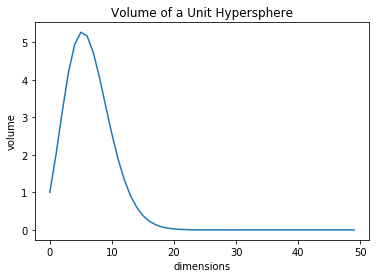

In [6]:
# from https://www.geeksforgeeks.org/python-math-library-gamma-function/  - math.gamma(x) computes the gamma value of x
# from p. 167 in Zaki text - use formula 6.10 or 6.11
# help from Kevin Angotti in other section and Torrey C. in class on Tuesday call

import math                  # to access the gamma method

x = []                       # create empty lists for x and y
y = []
for dimension in range(50):                             # to get 1 through 50
    d = float(dimension)                                # change it to a float and call it d
    volume = math.pi**(d/2)/math.gamma(d/2 + 1)         # formula from p. 167
    x.append(d)
    y.append(volume)
    
plt.plot(x,y)
plt.title('Volume of a Unit Hypersphere')
plt.xlabel('dimensions')
plt.ylabel('volume')
plt.show()


### 3b. Hypersphere Radius

What value of radius would one need to maintain a hypersphere volume of 1 with increasing d. Plot this value for d=1,⋯,100.

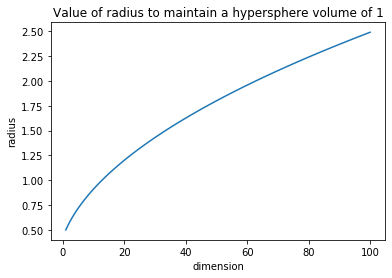

In [7]:
# help from classmate Andrea F.

x = []
y = []
dimension = 1

# loops through the d's, increasing by 1 each time.  That's the x-axis.  Result of the formula is the y-axis.
for dimension in range(1, 101):
    d = float(dimension)
    volume = math.pi**(d/2)/math.gamma(d/2 + 1)
    v = float(volume)
    r = (1/v)**(1/d)
    x.append(d)
    y.append(r)
    
plt.plot(x,y)
plt.title('Value of radius to maintain a hypersphere volume of 1')
plt.xlabel('dimension')
plt.ylabel('radius')
plt.show()

### 3c. Nearest Neighbors

Assume we have a unit hypercube centered at (0.5,⋯,0.5). Generate n=10000 uniformly random points in d dimensions, in the range (0,1) in each dimension. Find the ratio of the nearest and farthest point from the center of the space. Also store the actual distance of the nearest dn and farthest df points from the center. Plot these value for d=1,⋯,100.

In [8]:
# help from Andrea and https://mc-stan.org/users/documentation/case-studies/curse-dims-python.html
import numpy as np
import pandas as pd


def euclidean_length(x):                    # compute vector length
    return np.linalg.norm(x)                # numpy computes the norm of vector using np.linalg.norm() function

def get_center(d):                          # Function for center of hypercube
    center = []
    for val in range(d):
        center.append(.5)
    return np.array(center)

point_dict = {}                             # create dictionary for points

for d in range(1,101):                      # Arrays of values for each dimension
    dim_points = []
    for dim in range(1, d+1):
        dim_points.append(np.random.uniform(0,1,10000))
    point_dict[d] = zip(*dim_points)
    
distances = {}                              # create dictionary for distances

for dimension in point_dict.keys():         # loop through to get all distances for the 100 dimensions
    distance_list = []
    center = get_center(dimension)
    for point in point_dict[dimension]:
        distance = euclidean_length(point-center)
        distance_list.append(distance)
    distances[dimension] = distance_list
    

distance_df = pd.DataFrame(distances)       # Create dataframe to hold the distances dictionary


maxdist = []                                # create list for max distances
mindist = []                                # create list for min distances
ratios = []                                 # create list for ratios
dimensions = []                             # create list for dimensions

for dimension in range(1,101):
    maxdist.append(distance_df[dimension].max())
    mindist.append(distance_df[dimension].min())
    ratios.append(distance_df[dimension].min()/distance_df[dimension].max())
    dimensions.append(dimension)
    
sum_df = pd.DataFrame({'Dimensions': dimension, 'Furthest': maxdist, 'Closest': mindist, 'Ratio': ratios})
sum_df

Dimensions  Furthest   Closest     Ratio
0          100  0.499937  0.000099  0.000198
1          100  0.698952  0.007032  0.010061
2          100  0.846310  0.017913  0.021166
3          100  0.969925  0.041687  0.042979
4          100  1.036786  0.099301  0.095777
..         ...       ...       ...       ...
95         100  3.331309  2.366805  0.710473
96         100  3.293295  2.269520  0.689133
97         100  3.314412  2.257996  0.681266
98         100  3.367559  2.337096  0.694003
99         100  3.331068  2.336304  0.701368

[100 rows x 4 columns]

### 3d. Fraction of Volume

Assume we have a hypercube of edge length l=2 centered at the origin (0,0,⋯,0). Generate n=10,000 points uniformly at random for increasing dimensionality d=1,⋯,100. Now answer the following questions:

Plot the fraction of points that lie inside the largest hypersphere that can be inscribed inside the hypercube with increasing d. After how many dimensions does the fraction go to essentially zero?

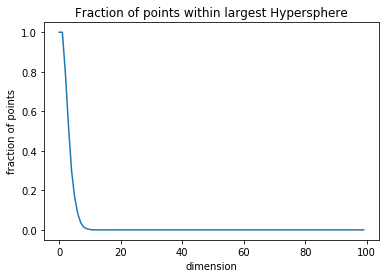

In [9]:
# from https://mc-stan.org/users/documentation/case-studies/curse-dims-python.html 
# and with help from classmates Torrey and Andrea

import numpy as np
from scipy.spatial.distance import euclidean

from scipy.spatial.distance import cdist
import scipy
import pandas as pd
import matplotlib.pyplot as plt

# generating points uniformly at random
fraction = {}                 # new dictionary
for d in range(100):
    points12 = np.random.uniform(-1,1,size=(10000,d))          
    dist = cdist(points12, np.expand_dims(np.zeros(d),0), metric = 'euclidean')   # calculates distance between two inputs
    dtest = np.sum(dist < 1)/10000
    fraction[d] = dtest
    
#plotting
distsort = sorted(fraction.items())

x,y = zip(*distsort)        

plt.plot(x,y)
plt.xlabel('dimension')
plt.ylabel('fraction of points')
plt.title('Fraction of points within largest Hypersphere')
plt.show()

# So I think what I read is that with increasing dimensionality, all the points will end up in the space outside the 
# hypersphere but within the hypercube.  Looks like this happens at around 7 dimensions.

Plot the fraction of points in the thin shell of width ϵ=0.01 inside the hypercube (i.e., the difference between the outer hypercube and inner hypercube, or the thin shell along the boundaries). What is the trend that you see? After how many dimensions does the fraction of volume in the thin shell go to 100% (use binary search or increase the dimensionality in steps of 10 to answer this. You may use maximum dimensions of up to 2000, and you may use a threshold of 0.0001 to count the volume as essentially being 1 in the shell, i.e., a volume of 0.9999 can be taken to be equal to 1 for finding the smallest dimension at which this happens).

Dimension where Proportion >= 0.9999: 917


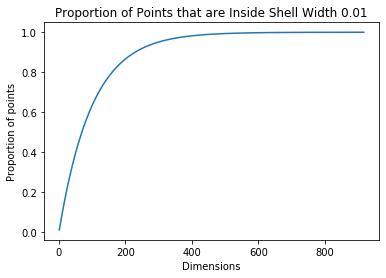

In [10]:
# help from Andrea and Zaki text pg 171-2

fractions = []                         # create list to hold fractions
dimensions = []                        # create list to hold dimensions

for dimension in range(1,2000):        # Used the max 2000
    fraction = 1-((0.99)**dimension)   # 'cuz we only want that tiny area inside the thin shell width 0.01
    dimensions.append(dimension)
    fractions.append(fraction)
    if fraction >= 0.9999:
        print('Dimension where Proportion >= 0.9999: {}'.format(dimension))
        break
x = dimensions
y = fractions
plt.plot(x,y)
plt.xlabel('Dimensions')
plt.ylabel('Proportion of points')
plt.title('Proportion of Points that are Inside Shell Width 0.01')
plt.show()

### 3e. Diagonals in High Dimensions

Your goal is the compute the empirical probability mass function (EPMF) for the random variable X that represents the angle (in degrees) between any two diagonals in high dimensions.

Assume that there are d primary dimensions (the standard axes in cartesian coordinates), with each of them ranging from -1 to 1. There are 2d additional half-diagonals in this space, one for each corner of the d-dimensional hypercube.

Write a script that randomly generates n=100000 pairs of half-diagonals in the d-dimensional hypercube, and computes the angle between them (in degrees).

In [12]:
#This was in Slack section from other class section
def compute_angle(point1, point2):
    return np.dot(point1, point2)/(np.linalg.norm(point1)*np.linalg.norm(point2))

def generate_all_angles(dimensions, pairs):
    results = np.zeros(pairs)
    for i in range(pairs):
        points = np.random.rand(2, dimensions)
        points[points<=0.5] = -1
        points[points>0.5] = 1
        results[i] = compute_angle(points[0], points[1])
    return results

#### Part i

Plot the EPMF for three different values of d, as follows d=10,100,1000.

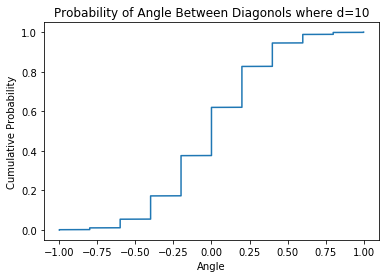

DescribeResult(nobs=100000, minmax=(-0.9999999999999998, 0.9999999999999998), mean=0.0013219999999999998, variance=0.10019405425654253, skewness=-2.5476001064276605e-05, kurtosis=-0.19817306230600362)


In [13]:
# Basing this off of link sent. It's ecdf instead of epmf 
# help from https://stackoverflow.com/questions/44132543/python-inverse-empirical-cumulative-distribution-function-ecdf

import scipy
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.distributions.empirical_distribution as edf

array_angles = generate_all_angles(10, 100000)
ecdf10 = edf.ECDF(array_angles)
plt.plot(ecdf10.x, ecdf10.y)
plt.xlabel('Angle')
plt.ylabel('Cumulative Probability')
plt.title('Probability of Angle Between Diagonols where d=10')
plt.show()
print(stats.describe(array_angles))

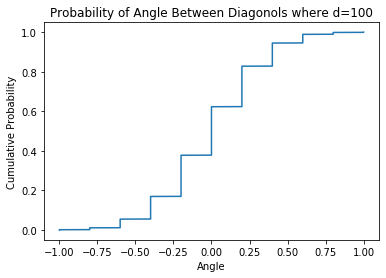

DescribeResult(nobs=100000, minmax=(-0.9999999999999998, 0.9999999999999998), mean=0.0003879999999999999, variance=0.09962884574445739, skewness=0.003995149433447265, kurtosis=-0.18952663741210962)


In [14]:
import scipy
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.distributions.empirical_distribution as edf

array_angles = generate_all_angles(10, 100000)
ecdf100 = edf.ECDF(array_angles)
plt.plot(ecdf100.x, ecdf100.y)
plt.xlabel('Angle')
plt.ylabel('Cumulative Probability')
plt.title('Probability of Angle Between Diagonols where d=100')
plt.show()
print(stats.describe(array_angles))

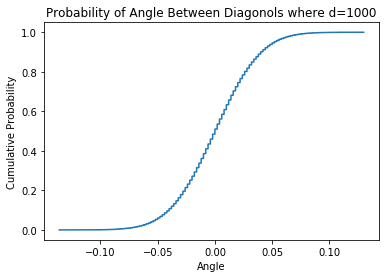

DescribeResult(nobs=100000, minmax=(-0.136, 0.13), mean=0.00022602, variance=0.001004775642716027, skewness=0.003826265205349034, kurtosis=0.018261494150435098)


In [15]:
array_angles = generate_all_angles(1000, 100000)
ecdf1000 = ECDF(array_angles)
pyplot.plot(ecdf1000.x, ecdf1000.y)
pyplot.xlabel('Angle')
pyplot.ylabel('Cumulative Probability')
pyplot.title('Probability of Angle Between Diagonols where d=1000')
pyplot.show()
print(stats.describe(array_angles))

#### Part ii

What is the min, max, value range, mean and variance of X for each value of d?

In [16]:
for i in array_angles:
    print(array_angles.min, array_angles.max)
    

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 0x0000014542DE3850> <built-in method max of numpy.ndarray object at 0x0000014542DE3850>
<built-in method min of numpy.ndarray object at 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 4. Textbook Exercise 3.1.1 (p. 82 in gold nugget book) - Compare the Jaccard Similarity of each pair of the following three sets: {1,2,3,4}, {2,3,5,7}, and {2,4,6}.

In [17]:
# from Prof. Deitenbeck's dog/cat example
# I need the size of the intersection of the two sets divided by the size of the union
# Apparently Python has functions or methods for each of those!  Then use length to count the resulting items.

def jaccard_similarity(list1, list2):
    s1 = set(list1)                                          # I have to change the list into a set for the functions to work
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))      # This is what gives me my answer

list1 = ['1', '2', '3', '4']
list2 = ['2', '3', '5', '7']
list3 = ['2','4','6']

jaccard_similarity(list1, list2)

0.3333333333333333

In [18]:
def jaccard_similarity(list1, list3):
    s1 = set(list1)
    s3 = set(list3)
    return len(s1.intersection(s3)) / len(s1.union(s3))

list1 = ['1', '2', '3', '4']
list2 = ['2', '3', '5', '7']
list3 = ['2','4','6']

jaccard_similarity(list1, list3)

0.4

In [19]:
def jaccard_similarity(list2, list3):
    s2 = set(list2)
    s3 = set(list3)
    return len(s2.intersection(s3)) / len(s2.union(s3))

list1 = ['1', '2', '3', '4']
list2 = ['2', '3', '5', '7']
list3 = ['2','4','6']

jaccard_similarity(list2, list3)

0.16666666666666666

## 5. Textbook Exercise 3.2.1 (p. 85) What are the first ten 3-shingles in the first sentence of Section 3.2? "The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it."

In [ ]:
# OK so this is wrong because it splits the sentence into words.  Like, four hours wasted...
# https://www.geeksforgeeks.org/python-spilt-a-sentence-into-list-of-words/    showed me how to change the sentence into a list
# Convert single indexed list (which is the sentence) into a multiple indexed list
'''
def convert(lst): 
    return (lst[0].split()) 
  
# Driver code 
lst =  ["The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it"] 
print(convert(lst))
list1 = (convert(lst))

def generate_shingles(list1,k=11):
    new_list = []
    for i in list1:
        new_list = new_list.append(['i','i'+i[1],'i'+i[2]])  # I want to take that item plus the next two items in list 1...
        #....and add them as a tuple in new_list
    return new_list

print(generate_shingles(list1,k=11))
# AttributeError: 'NoneType' object has no attribute 'append'
'''
'''
ss = ["The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it."]
list_one = []
# t = 
for i in ss:
    #i = ss[0]
    list_one = list_one.append[ss[0], ss[1], ss[2]]
    #, ss[1], ss[2]]

print('list_one')
'''

In [ ]:
# SAVE this code.  I spent HOURS on it.  Still not working, though.
'''
ss = ["The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it."]

def shingler():
    count_i = 0                         # my loop counter
    while(count_i >= 0 and count_i < 11):
        list_one = []
        i = 0
        for i in ss:
            #list_one = list_one.extend(ss(int([len(i)])) + ss(int([len(i+1)]) + ss(int([len(i+2)])      - or is it .extend?
            list_one.extend(ss(int([len(i)])) + ss(int([len(i+1)]) + ss(int([len(i+2)])                                                                      
            count_i = count_i + 1
                                                                        
    return list_one
                                                                                   
shingler()
'''

In [ ]:
# DO NOT LOSE THIS PART!  (Not working, though).
'''
x = "The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it."
my_list = list(x)   # Change the string to a list

def make_shingles(my_list, k=10):
    new_list = []
    for i in range(k<=10):              # I think I have to go to 12 so I get the next two elements after i of 10
        new_list = new_list.append([my_list[0], my_list[1], my_list[2]])
        return new_list

results = make_shingles(my_list)
print(new_list)                             # Nothing is getting added to my_list!
'''

In [20]:
# with help from a classmate (who felt the need to shingle the sentence by both letters AND words!)
# from  http://stuartmyles.blogspot.com/2012/07/shingling-in-python.html
import traceback

def main():
    ss = 'The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it.'
    k = 3                            # variable for substring length
     
    try:                             # try block for execution
        print('\nSentence:\n' + ss)               
        
        sentence_list = [ss[i:i + k] for i in range(0,10)]   # step thru sentence & create list of 10 groups of 3 letters each
        print('\nFirst 10 3-shingles in sentence (based on letters):\n')     # print each list value
        for i in range(0,len(sentence_list)):
            print(str(i+1) + ': [' + sentence_list[i] + ']\n')
        
        tokens = ss.split()           # Split sentence into words
        word_list = [tokens[i:i + k] for i in range(0,10)]     # Step thru words & create list of 10 groups of 3 words each
        
        print('\nFirst 10 3-shingles in sentence (based on words):\n')
        for i in range(0, len(word_list)):
            print(str(i+1) + ': ' + str(word_list[i]) +'\n')
        
    # exception block to catch any exceptions during execution
    except Execution as exception:
        print('exception')
        traceback.print_exc()        # Print the traceback of the exception
        # list name of exception and any arguments
        print('An exception of type {0} occurred.  Arguments:\n{1!r}'.format(type(exception).__name__,exception.args));
        
if __name__ == '__main__':
    main()


Sentence:
The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it.

First 10 3-shingles in sentence (based on letters):

1: [The]

2: [he ]

3: [e m]

4: [ mo]

5: [mos]

6: [ost]

7: [st ]

8: [t e]

9: [ ef]

10: [eff]


First 10 3-shingles in sentence (based on words):

1: ['The', 'most', 'effective']

2: ['most', 'effective', 'way']

3: ['effective', 'way', 'to']

4: ['way', 'to', 'represent']

5: ['to', 'represent', 'documents']

6: ['represent', 'documents', 'as']

7: ['documents', 'as', 'sets,']

8: ['as', 'sets,', 'for']

9: ['sets,', 'for', 'the']

10: ['for', 'the', 'purpose']



## 6. Textbook Exercise 3.3.3

In [21]:
# from https://www.bogotobogo.com/Algorithms/minHash_Jaccard_Similarity_Locality_sensitive_hashing_LSH.php
# since the code was from 2017 I had to change a couple things;  maxint became maxsize.  map() became list(map()).

import sys
import pandas as pd
import numpy as np

def h1(x):
    return ((2 * x) + 1) % 6             # creates a set of permutations of the matrix using this formula on the row numbers
def h2(x):
    return ((3 * x) + 2) % 6
def h3(x):
    return ((5 * x) + 2) % 6

def minhash(data, hashfuncs):                                          # Returns signature matrix
    rows, cols, sigrows = len(data), len(data[0]), len(hashfuncs)      # Initialize variables
    
    # initialize signature matrix with maxsize
    sigmatrix = []
    for i in range(sigrows):                                           # Loop through rows to fill signature matrix
        sigmatrix.append([sys.maxsize] * cols)
        
    for r in range(rows):
        hashvalue = list(map(lambda x: x(r), hashfuncs))
        # if data != 0 and signature > hash value, replace signature with hash value
        for c in range(cols):
            if data[r][c] == 0:
                continue
            for i in range(sigrows):                                   # If sigmatrix value > hashvalue, replace with hashvalue
                if sigmatrix[i][c] > hashvalue[i]:
                    sigmatrix[i][c] = hashvalue[i]
                    
    return sigmatrix
    
if __name__ == '__main__':
    
    data = [[0, 1, 0, 1],
           [0, 1, 0, 0],
           [1, 0, 0, 1],
           [0, 0, 1, 0],
           [0, 0, 1, 1],
           [1, 0, 0, 0]]
    
    # print signature matrix
    # print(minhash(data, [h1, h2, h3]))      (what the original author did, but I want them stacked like a minhash signature)
    in_array = np.array((minhash(data, [h1, h2, h3])))                 # Create a multi-dimensional array
    # (a)
    print('3.3.3 (a) The minhash signature for each column is:')
    print(in_array)
    # (b)
    print('3.3.3 (b) None of these hash functions are true permutations because the number of rows, 6, is NOT a prime.  But \n a classmate told me h3 is a true permutation because none of the results in the minhash signature repeat.')
    # (c)
    print('3.3.3 (c) The estimated Jaccard similarities are not close to the true Jaccard similarities. \n The h2 minhash signature, consisting of all 2s, results in each pair automatically having a match. \n In reality, three of the five sets have no match.')
    

3.3.3 (a) The minhash signature for each column is:
[[5 1 1 1]
 [2 2 2 2]
 [0 1 4 0]]
3.3.3 (b) None of these hash functions are true permutations because the number of rows, 6, is NOT a prime.  But 
 a classmate told me h3 is a true permutation because none of the results in the minhash signature repeat.
3.3.3 (c) The estimated Jaccard similarities are not close to the true Jaccard similarities. 
 The h2 minhash signature, consisting of all 2s, results in each pair automatically having a match. 
 In reality, three of the five sets have no match.


## 7. Textbook Exercise 3.4.1 Evaluate the S-curve: 1-(1-s**r)**b for s=0.1,0.2,...,0.9, for the following values of r and b:  r=3 and b=10, r=6 and b=20, r=5 and b=50.

Row value: 3, Band value: 10


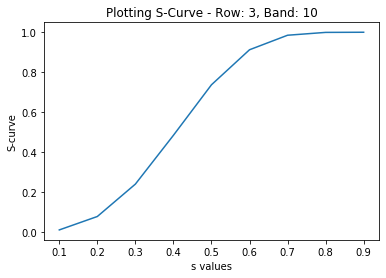

Row value: 6, Band value: 20


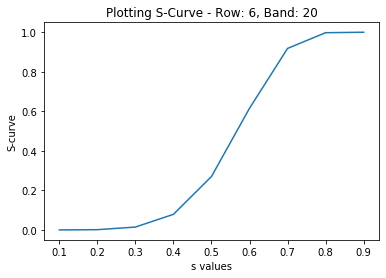

Row value: 5, Band value: 50


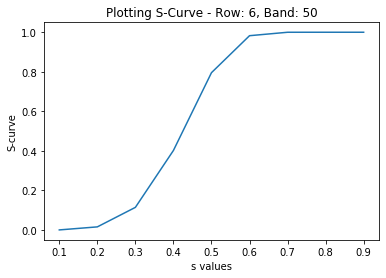

"Where this program actually starts doing something is within the 'try' statement.  It goes to compute_s_curve() and sends the first row/band combination.  Then it takes the result of that and sends it to the plot_s_curve() along with the string values for row and band names.  I'm not certain why strings.  I'm also a little fuzzy on how the results of compute_s_curve, which I've called 's_curve', get put into plot_s_curve() as 's_curve_list'.  It must be an automatic re-naming because of plot_s_curve() recognizing that s_curve is its first argument.  Then the str(r1) and str(b1) are the second and third arguments. As the number of bands checked increases, the code becomes more precise in the results.  The 'gold nugget' (Leskovek) text says that's because the more bands I use, the more chances that a vector has to be candidate pair in one of the bands.  Each band is a chance for a part of the signature matrix to match up."

In [22]:
# A classmate helped me with this

import traceback                  # for error checking
import matplotlib.pyplot as plt

r1 = 3                            # create variables for values of rows and bands 
b1 = 10
r2 = 6
b2 = 20
r3 = 5
b3 = 50

s_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]          # list of s values

def compute_s_curve(row,band):                            # the arguments come from within the 'try' statement under def main()
    print('Row value: {}, Band value: {}'.format(row,band))
    s_curve = []                                          # new empty list for results of the for loop
    for i in range(0, len(s_values)):
        s_curve.append(1-(1-s_values[i]**row)**band)
    return s_curve                                        # this becomes the first argument in plot_s_curve()

def plot_s_curve(s_curve_list, row_name, band_name):
    x = s_values                   # x axis values
    y = s_curve_list               # y axis values
    
    plt.plot(x,y)                  # plot the points
    
    plt.xlabel('s values')        
    plt.ylabel('S-curve')         
    
    plt.title('Plotting S-Curve - Row: ' + row_name + ', Band: ' + band_name)
    plt.show()
    
def main():
    try:
        # error checking; call to compute and plot S-curve for all three sets of rows and bands
        plot_s_curve(compute_s_curve(r1,b1), str(r1), str(b1))
        plot_s_curve(compute_s_curve(r2,b2), str(r2), str(b2))
        plot_s_curve(compute_s_curve(r3,b3), str(r2), str(b3))
    except:
        print('exception')
        traceback.print_exc()       # print the traceback of the exception
        print('An exception of type{0} occurred.  Arguments:\n{1!r}'.format(type(exception).__name__, exception.args));
        
if __name__ == '__main__':
    main()           

'''Where this program actually starts doing something is within the 'try' statement.  It goes to compute_s_curve() and sends the first row/band combination.  Then it takes the result of that and sends it to the plot_s_curve() along with the string values for row and band names.  I'm not certain why strings.  I'm also a little fuzzy on how the results of compute_s_curve, which I've called 's_curve', get put into plot_s_curve() as 's_curve_list'.  It must be an automatic re-naming because of plot_s_curve() recognizing that s_curve is its first argument.  Then the str(r1) and str(b1) are the second and third arguments. As the number of bands checked increases, the code becomes more precise in the results.  The 'gold nugget' (Leskovek) text says that's because the more bands I use, the more chances that a vector has to be candidate pair in one of the bands.  Each band is a chance for a part of the signature matrix to match up.'''